In [1]:
import pandas as pd, GPy, seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [15]:
#data_type = 'microarray'
data_type = 'rnaseq'

In [16]:
%%file collect_and_name_data.py
import sys

execfile('load_data.py')

if sys.argv[1] in 'rnaseq':
    all_data = [
        rnaseq_all_genes,#: (11216, 104)
        rnaseq_effector_genes,#: (1044, 104)
        rnaseq_mod_activities,#: (89, 104)
        rnaseq_mod_genevalues,#: (172, 104)
        rnaseq_mod_nodevalues,#: (462, 104)
        rnaseq_signaling_genes,#: (2184, 104)
    #    rnaseq_design: (104, 4)
    ]
    design = rnaseq_design
else:
    all_data = [
        micro_all_genes,#: (13613, 105)
        micro_effector_genes,#: (1044, 105)
        micro_mod_activities,#: (89, 105)
        micro_mod_genevalues,#: (201, 105)
        micro_mod_nodevalues,#: (462, 105)
        micro_signaling_genes,#: (2184, 105)
        #micro_design,#: (105, 4)
    ]
    design = micro_design

names = ['all_genes', 
         'effector_genes', 
         'mod_activities', 
         'mod_genevalues', 
         'mod_nodevalues',
         'signaling_genes'
         ]

for y,n in zip(all_data, names):
    y.name = n

Overwriting collect_and_name_data.py


In [18]:
%run collect_and_name_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [19]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding, Isomap
from sklearn.decomposition import FastICA, PCA

methods = {'t-SNE':TSNE(n_components=2),
           'PCA':PCA(n_components=2), 
           'Spectral': SpectralEmbedding(n_components=2, n_neighbors=10), 
           'Isomap': Isomap(n_components=2, n_neighbors=10), 
           'ICA': FastICA(n_components=2)
           }

In [20]:
import numpy as np

def run_methods(Y, methods):
    order = methods.keys()
    dims = {}
    i = 0
    for name in order:
        method = methods[name]
        q = method.n_components
        dims[name] = slice(i, i+q)
        i += q

    latent_spaces = np.empty((Y.shape[0], i))

    for name in methods:
        method = methods[name]
        try:
            _lat = method.fit_transform(Y)
            latent_spaces[:, dims[name]] = _lat
        except:
            raise
            print("Error detected in running method, ignoring this method as NAN")
    latent_spaces -= latent_spaces.mean(0)
    latent_spaces /= latent_spaces.std(0)
    return latent_spaces, dims

## Run other methods on all datasets

In [21]:
def plot_comparison(X_init, dims, m, labels, savename=None):
    fig, axes = plt.subplots(2,3,figsize=(10,6))
    axit = axes.flat
    cmap = (c for c in sns.color_palette('rainbow', n_colors=len(np.unique(labels))))
    cols = dict()
    ulabels = []
    for lab in labels:
        if lab not in ulabels:
            ulabels.append(lab)
            cols[lab] = next(cmap)
    
    ax = next(axit)
    msi = m.get_most_significant_input_dimensions()[:2]
    
    m.plot_magnification(resolution=20, plot_scatter=False, ax=ax)#scatter_kwargs=dict(s=20, ), marker='o', ax=ax, labels=labels)
    for lab in ulabels:
        ax.scatter(*m.X.mean.values[labels==lab][:,msi].T, c=cols[lab], cmap=cmap, lw=.1, label=lab)

    #ax.set_title('BGPLVM')
    ax.text(.01, 1-.02, 'BGPLVM', ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

    
    for name in methods:
        ax = next(axit)
        for lab in ulabels:
            ax.scatter(*X_init[labels==lab][:,dims[name]].T, c=cols[lab], cmap=cmap, lw=.1, label=lab)
        #ax.set_title(name)
        ax.text(.01, 1-.02, name, ha='left', va='top', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])

    axes.flat[0].legend(bbox_to_anchor=(0., 1.02, 3., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0., frameon=False)
        
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename, transparent=True, bbox_inches='tight')
    return fig

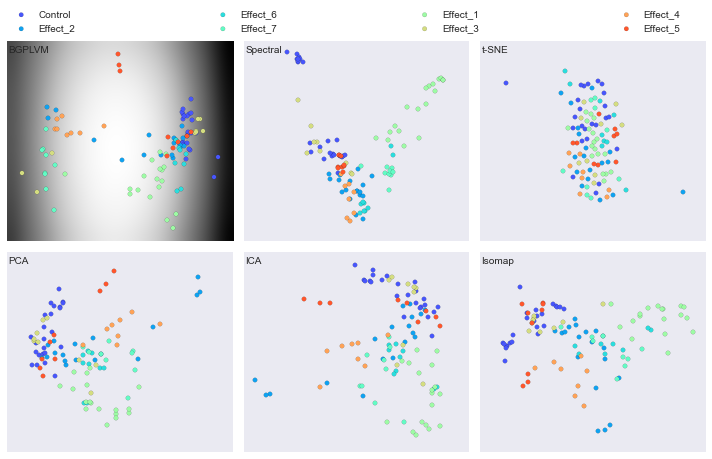

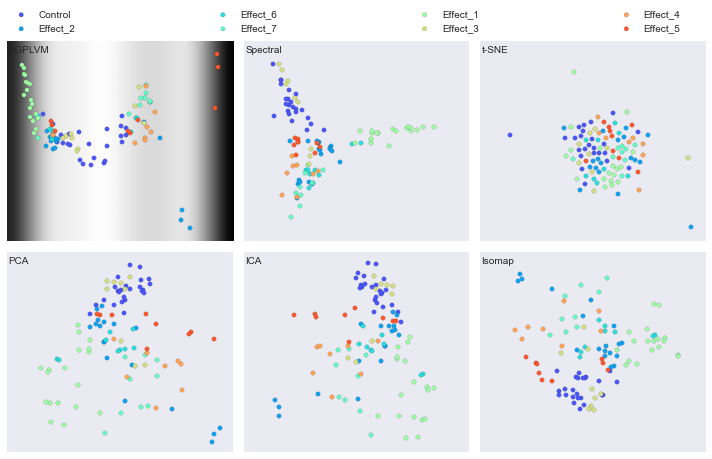

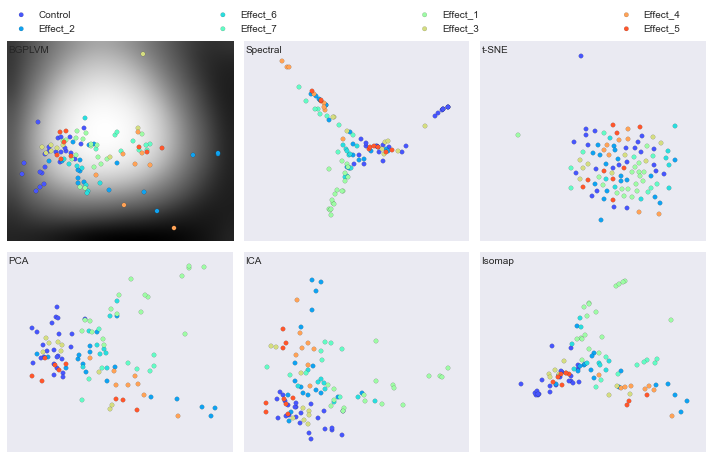

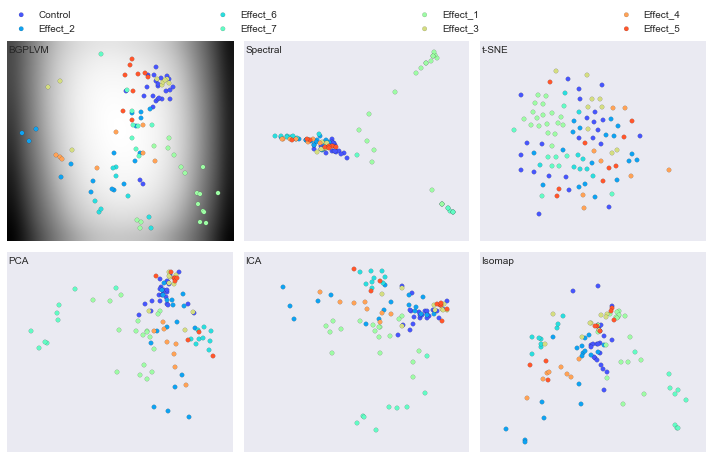

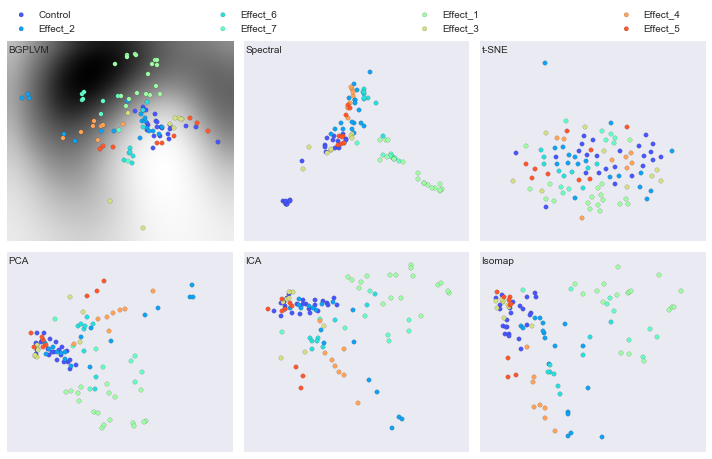

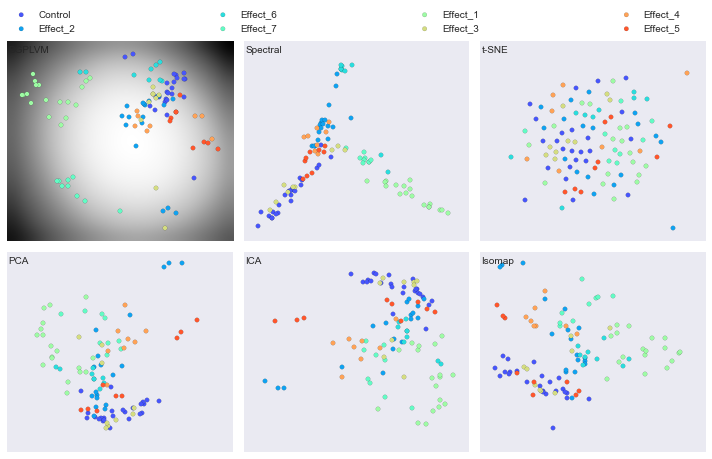

In [22]:
if data_type in 'rnaseq':
    savedir = '../diagrams/dim_reduction/rnaseq/'
else:
    savedir = '../diagrams/dim_reduction/microarray/'

for dat in all_data:
    Y = dat.values.T.copy()
    Y -= Y.mean()
    
    X_init, dims = run_methods(Y, methods)

    k = GPy.kern.RBF(10, ARD=True)
    m = GPy.models.BayesianGPLVM(Y, 10, X=X_init, num_inducing=25, kernel=k)
    
    messages = 0

    m.likelihood.fix(Y.var()/10)
    m.X.variance.fix(Y.var()/100)
    
    m.optimize(messages=messages, max_iters=600)

    m.X.variance.unfix()
    m.optimize(messages=messages, max_iters=600)

    m.likelihood.unfix()
    m.optimize(messages=1, max_iters=3e5)
    
    plot_comparison(X_init, dims, m, design.Effect.values, savename=os.path.join(savedir, "{}.pdf".format(dat.name)))
